# Modèles de Machine Learning sur le type de plante (14 classes) pour les images de New Plant Disease

## 0 Importation des bibliothèques nécessaires

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
import joblib
import os

## 1 Préparation des données

### 1.1 Installation du Drive

In [2]:
#Pour Google Colab, installation du drive
#Installation du drive
from google.colab import drive
drive.mount('/content/drive')
#Attention, attendre que le Drive soit réellement monté avant de poursuivre

Mounted at /content/drive


## 1.2 Répertoire de sauvegarde des modèles


In [6]:
# Pour une utilisation sous Google Drive
# Vérification de la présence du répertoire de sauvegarde des modèles
pathRep_mod = "/content/drive/MyDrive/ProjetPlantes/Donnees/modeles"
os.makedirs(pathRep_mod, exist_ok=True)

### 1.3 Création du dataFrame à partir du fichier df_HistInt_NPD.csv

In [7]:
#Chemin du fichier df_HistInt_NPD.csv
ficHistInt_csv = "/content/drive/MyDrive/ProjetPlantes/Donnees/df_HistInt_NPD.csv"
dtype = {'Suffixe': str,'Luminosite': str}
df_HistInt_NPD = pd.read_csv(ficHistInt_csv, dtype=dtype)
df_HistInt_NPD.head()

,Categorie,Plante,Maladie,Saine,Set,Suffixe,Luminosite,0,1,2,...,698,699,700,701,702,703,704,705,706,707
0,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,75.0,93.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,8.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,1013.0,1174.0,1255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,NaN,0,3.0,5.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#La colonne Suffixe a des NaN. On remplace ceux-ci par ""
df_HistInt_NPD["Suffixe"] = df_HistInt_NPD["Suffixe"].fillna("")
df_HistInt_NPD["Suffixe"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 87863 entries, 0 to 87862
Series name: Suffixe
Non-Null Count  Dtype 
--------------  ----- 
87863 non-null  object
dtypes: object(1)
memory usage: 686.6+ KB


In [9]:
df_HistInt_NPD.head()

,Categorie,Plante,Maladie,Saine,Set,Suffixe,Luminosite,0,1,2,...,698,699,700,701,702,703,704,705,706,707
0,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,75.0,93.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,8.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,1013.0,1174.0,1255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,,0,3.0,5.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.4 Sélection des données

In [10]:
#Le diagramme d'intensité d'une image transformée avec rotation ou symétrie aura le même diagramme d'intensité que son image
#d'origine, il n'y a donc théoriquement pas d'intérêt de sélectionner les images avec suffixe

#Création de deux dataFrames distinsts, un pour chaque environnement (train et valid)
df_Select_train = df_HistInt_NPD[(df_HistInt_NPD['Suffixe'] == "") & (df_HistInt_NPD['Set'] == "train")]
df_Select_valid = df_HistInt_NPD[(df_HistInt_NPD['Suffixe'] == "") & (df_HistInt_NPD['Set'] == "valid")]

In [11]:
df_Select_train['Plante'].value_counts()

Tomato                     12238
Grape                       3246
Corn_(maize)                3067
Apple                       2557
Peach                       2123
Soybean                     2022
Orange                      2010
Pepper,_bell                1987
Potato                      1720
Cherry_(including_sour)     1515
Squash                      1467
Strawberry                  1254
Blueberry                   1186
Raspberry                    290
Name: Plante, dtype: int64

In [12]:
#Cependant avec uniformisation des classes par undersampling, il ne restera plus beaucoup d'images par type de plante.
# On va donc prendre les images avec suffixe qui permettent de réduire la différence d'images entre les différentes classes
#Cependant on ne va pas retenir les images avec transformation de luminosité pour lesquelles le diagramme d'intensité est
#complètement différent que le diagramme d'intensité de l'image de initiale.
#Réinitiaisation des 2 dataframes sans faire de sélection sur le suffixe
df_Select_train = df_HistInt_NPD[(df_HistInt_NPD['Luminosite'] == "0") & (df_HistInt_NPD['Set'] == "train")]
df_Select_valid = df_HistInt_NPD[(df_HistInt_NPD['Luminosite'] == "0") & (df_HistInt_NPD['Set'] == "valid")]
df_Select_train['Plante'].value_counts()

Tomato                     17695
Apple                       7348
Corn_(maize)                7316
Grape                       7222
Potato                      5332
Pepper,_bell                3695
Strawberry                  3598
Cherry_(including_sour)     3509
Peach                       3285
Soybean                     2022
Orange                      2010
Squash                      1736
Blueberry                   1663
Raspberry                   1487
Name: Plante, dtype: int64

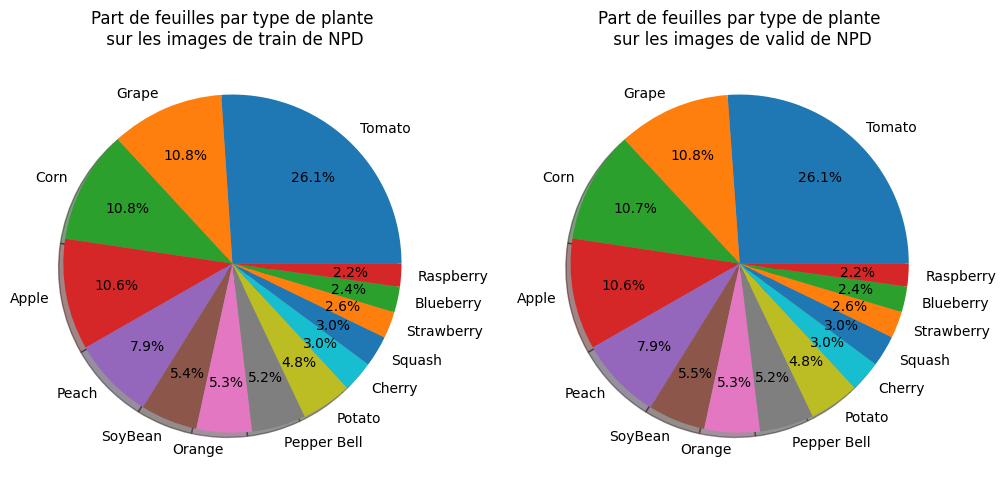

In [13]:
#répartition des feuilles par type de plantes dans chaque jeu de données train et valid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.pie(x=df_Select_train['Plante'].value_counts(),
        labels=['Tomato', 'Grape', 'Corn', 'Apple', 'Peach', 'SoyBean', 'Orange', 'Pepper Bell', 'Potato', 'Cherry', 'Squash', 'Strawberry', 'Blueberry', 'Raspberry'],
        autopct='%1.1f%%',
        pctdistance=0.7,
        labeldistance=1.1,
        shadow=True)
plt.title("Part de feuilles par type de plante\n sur les images de train de NPD");


plt.subplot(122)
plt.pie(x=df_Select_valid['Plante'].value_counts(),
        labels=['Tomato', 'Grape', 'Corn', 'Apple', 'Peach', 'SoyBean', 'Orange', 'Pepper Bell', 'Potato', 'Cherry', 'Squash', 'Strawberry', 'Blueberry', 'Raspberry'],
        autopct='%1.1f%%',
        pctdistance=0.7,
        labeldistance=1.1,
        shadow=True)
plt.title("Part de feuilles par type de plante\n sur les images de valid de NPD");

In [14]:
#Préparation des tables target et data pour équilibrer les nombres de feuilles par type de plante pour chaque jeu de données
target_train = df_Select_train['Plante']
target_valid = df_Select_valid['Plante']
#suppression de toutes les colonnes autres que celles des histogrammes d'intensité
colonnes = ['Categorie','Plante','Maladie','Saine','Set','Suffixe','Luminosite']
data_train = df_Select_train.drop(colonnes,axis=1)
data_valid = df_Select_valid.drop(colonnes,axis=1)

## 2 Classification par type de plantes avec uniformisation des classes

### 2.1 Undersampling des données

In [15]:
#Les classes ne sont pas équilibrées, on va faire de l'undersampling
rus = RandomUnderSampler()

In [16]:
#Undersampling des données de train
X_train, y_train = rus.fit_resample(data_train,target_train)
#Nb d'éléments par classe pour train
y_train.value_counts()

Apple                      1487
Blueberry                  1487
Cherry_(including_sour)    1487
Corn_(maize)               1487
Grape                      1487
Orange                     1487
Peach                      1487
Pepper,_bell               1487
Potato                     1487
Raspberry                  1487
Soybean                    1487
Squash                     1487
Strawberry                 1487
Tomato                     1487
Name: Plante, dtype: int64

In [60]:
#Undersampling des données de valid
X_test, y_test = rus.fit_resample(data_valid,target_valid)
#Nb d'éléments par classe pour valid
y_test.value_counts()

Apple                      368
Blueberry                  368
Cherry_(including_sour)    368
Corn_(maize)               368
Grape                      368
Orange                     368
Peach                      368
Pepper,_bell               368
Potato                     368
Raspberry                  368
Soybean                    368
Squash                     368
Strawberry                 368
Tomato                     368
Name: Plante, dtype: int64

### 2.2 Modèle de classification Random Forest

In [18]:
#Modèle de classification Random Forest
modelRF = RandomForestClassifier(n_jobs = -1)
# Entraînement
modelRF.fit(X_train,y_train)
# Prédiction
test_pred_RF = modelRF.predict(X_test)
score_RF = accuracy_score(y_test,test_pred_RF)
print("Le score de précision est : ",score_RF*100, "%")

Le score de précision est :  85.7336956521739 %


In [30]:
# Compte-rendu évaluatif détaillé de la classification Random Forest
print("compte rendu évaluatif détaillé de la classification Random Forest \n", classification_report(y_test,test_pred_RF))

compte rendu évaluatif détaillé de la classification Random Forest 
                          precision    recall  f1-score   support

                  Apple       0.80      0.66      0.73       368
              Blueberry       0.89      0.96      0.93       368
Cherry_(including_sour)       0.84      0.82      0.83       368
           Corn_(maize)       0.91      0.91      0.91       368
                  Grape       0.83      0.81      0.82       368
                 Orange       0.90      0.92      0.91       368
                  Peach       0.87      0.82      0.84       368
           Pepper,_bell       0.78      0.77      0.77       368
                 Potato       0.83      0.90      0.86       368
              Raspberry       0.91      0.99      0.95       368
                Soybean       0.90      0.91      0.91       368
                 Squash       0.89      0.96      0.92       368
             Strawberry       0.89      0.94      0.92       368
                 Tom

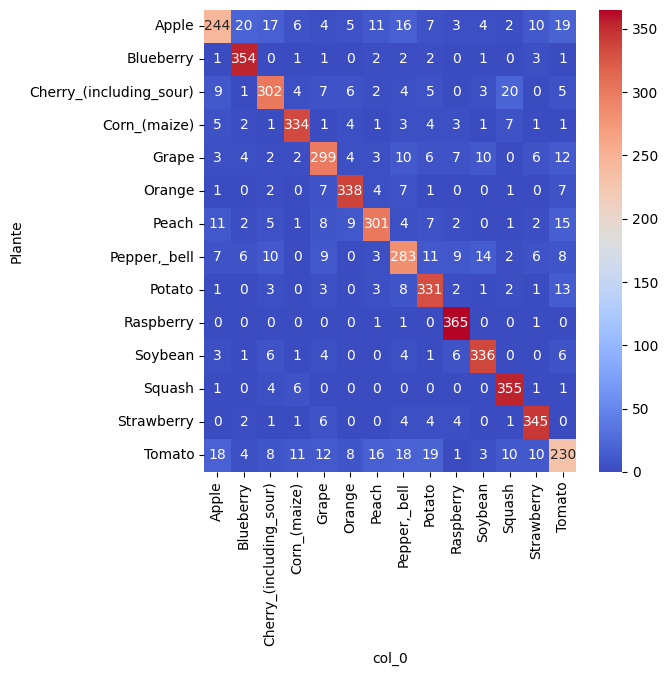

In [29]:
#Heatmap des corrélations
cor = pd.crosstab(y_test, test_pred_RF)
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [31]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelRF_14.pkl'
joblib.dump(modelRF, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/modeles/modelRF_14.pkl']

### 2.3 Modèle de classification par régression logistique

In [ ]:
#Modèle de classification régression logistique
modelLR = LogisticRegression(C=1.0,max_iter=1000,solver='newton-cg')
# Entraînement
modelLR.fit(X_train,y_train)
# Prédiction
test_pred_LR = modelLR.predict(X_test)
score_LR = accuracy_score(y_test,test_pred_LR)
print("Le score de précision est : ",score_LR*100, "%")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Le score de précision est :  59.12267080745342 %


In [42]:
# Compte-rendu évaluatif détaillé de la classification par régression logistique
print("compte rendu évaluatif détaillé de la classification par régression logistique \n", classification_report(y_test,test_pred_LR))

compte rendu évaluatif détaillé de la classification par régression logistique 
                          precision    recall  f1-score   support

                  Apple       0.34      0.35      0.35       368
              Blueberry       0.80      0.83      0.81       368
Cherry_(including_sour)       0.46      0.43      0.45       368
           Corn_(maize)       0.59      0.60      0.59       368
                  Grape       0.47      0.43      0.45       368
                 Orange       0.70      0.76      0.72       368
                  Peach       0.57      0.56      0.56       368
           Pepper,_bell       0.48      0.44      0.46       368
                 Potato       0.55      0.45      0.50       368
              Raspberry       0.72      0.83      0.77       368
                Soybean       0.72      0.73      0.72       368
                 Squash       0.69      0.77      0.73       368
             Strawberry       0.63      0.64      0.63       368
        

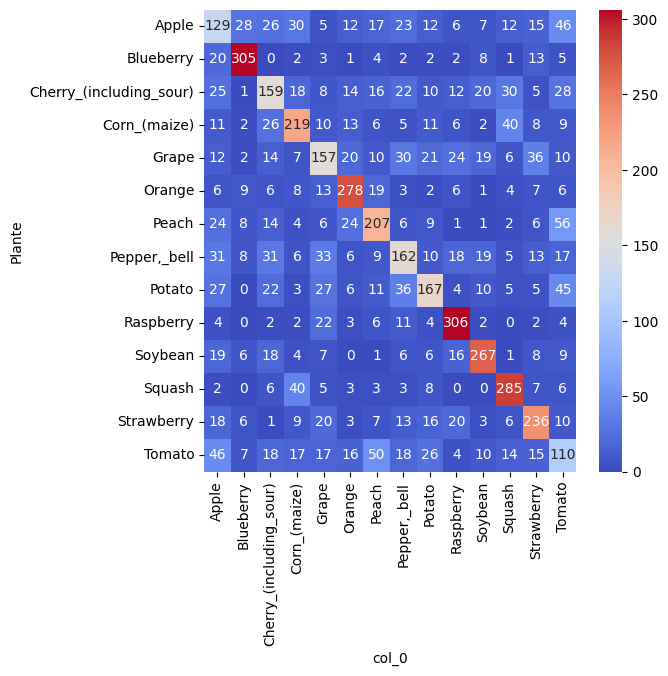

In [43]:
#Heatmap des corrélations
cor = pd.crosstab(y_test, test_pred_LR)
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [ ]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelRL_14.pkl'
joblib.dump(modelLR, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/ModRL_14.pkl']

### 2.4 Modèle de classification par SVM

In [44]:
#Modèle de classification SVM
modelSVM = SVC(gamma=0.01, kernel = 'poly')
# Entraînement
modelSVM.fit(X_train,y_train)
# Prédiction
test_pred_SVM = modelSVM.predict(X_test)
score_SVM = accuracy_score(y_test,test_pred_SVM)
print("Le score de précision est : ",score_SVM*100, "%")

Le score de précision est :  87.32531055900621 %


In [45]:
# Compte-rendu évaluatif détaillé de la classification SVM
print("compte rendu évaluatif détaillé de la classification SVM \n", classification_report(y_test,test_pred_SVM))

compte rendu évaluatif détaillé de la classification SVM 
                          precision    recall  f1-score   support

                  Apple       0.72      0.80      0.75       368
              Blueberry       0.96      0.97      0.96       368
Cherry_(including_sour)       0.84      0.89      0.86       368
           Corn_(maize)       0.88      0.90      0.89       368
                  Grape       0.83      0.88      0.85       368
                 Orange       0.91      0.91      0.91       368
                  Peach       0.85      0.80      0.82       368
           Pepper,_bell       0.86      0.81      0.84       368
                 Potato       0.87      0.88      0.87       368
              Raspberry       0.96      0.99      0.98       368
                Soybean       0.93      0.88      0.91       368
                 Squash       0.94      0.92      0.93       368
             Strawberry       0.94      0.96      0.95       368
                 Tomato       

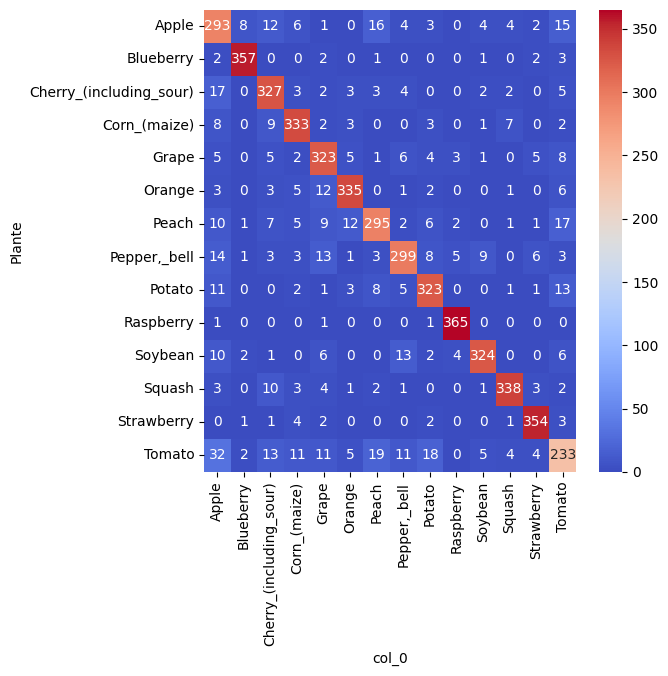

In [61]:
#Heatmap des corrélations
cor = pd.crosstab(y_test, test_pred_SVM)
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [47]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelSVM_14.pkl'
joblib.dump(modelSVM, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/modeles/modelSVM_14.pkl']

### 2.4 Modèle de classification par XGBoots

In [53]:
#Transformation des classes de y_train et y_test par un chiffre au lieu des chaines de caractères
#Il faut concaténer y_train et y_test afin que la correspondance libellé et numéro soit la même pour les deux dataframes
y_cumul = pd.concat([y_train, y_test])

# Utilisation de la méthode factorize sur les colonnes combinées
y_cumul_num, corresp_classe = pd.factorize(y_cumul)

# Mise à jour des colonnes dans les DataFrames originaux
y_train = y_cumul_num[:len(y_train)]
y_test = y_cumul_num[len(y_train):]

In [54]:
#Séparation des données de test en 2 parties
X_test2, X_valid, y_test2, y_valid = train_test_split(X_test, y_test, test_size = 0.5)
#Création des objets DMAtrix
train = xgb.DMatrix(data=X_train,label=y_train)
test = xgb.DMatrix(data=X_test2,label=y_test2)
valid = xgb.DMatrix(data=X_valid,label=y_valid)

In [ ]:
paramsXGB = {'booster' : 'gbtree', 'learning_rate' : 0.01, 'objective' : 'multi:softmax', 'num_class': 14}
modelXGB = xgb.train(params = paramsXGB, dtrain = train, num_boost_round = 500, early_stopping_rounds= 15, evals= [(train, 'train'), (test, 'eval')])

[0]	train-mlogloss:2.60418	eval-mlogloss:2.60779
[1]	train-mlogloss:2.57072	eval-mlogloss:2.57803
[2]	train-mlogloss:2.53869	eval-mlogloss:2.54985
[3]	train-mlogloss:2.50790	eval-mlogloss:2.52200
[4]	train-mlogloss:2.47832	eval-mlogloss:2.49539
[5]	train-mlogloss:2.44965	eval-mlogloss:2.46953
[6]	train-mlogloss:2.42212	eval-mlogloss:2.44468
[7]	train-mlogloss:2.39548	eval-mlogloss:2.42065
[8]	train-mlogloss:2.36956	eval-mlogloss:2.39746
[9]	train-mlogloss:2.34463	eval-mlogloss:2.37515
[10]	train-mlogloss:2.32056	eval-mlogloss:2.35327
[11]	train-mlogloss:2.29701	eval-mlogloss:2.33213
[12]	train-mlogloss:2.27401	eval-mlogloss:2.31150
[13]	train-mlogloss:2.25162	eval-mlogloss:2.29176
[14]	train-mlogloss:2.22998	eval-mlogloss:2.27239
[15]	train-mlogloss:2.20895	eval-mlogloss:2.25330
[16]	train-mlogloss:2.18838	eval-mlogloss:2.23486
[17]	train-mlogloss:2.16823	eval-mlogloss:2.21695
[18]	train-mlogloss:2.14861	eval-mlogloss:2.19938
[19]	train-mlogloss:2.12952	eval-mlogloss:2.18239
[20]	train

In [56]:
#Stocke les prédictions sur valid
valid_pred_XGB = modelXGB.predict(valid)
score_XGB = accuracy_score(y_valid, valid_pred_XGB)
print("Le score de précision est : ",score_XGB*100, "%")
#Transformation des prédictions et target pour remettre le libellé de la classe
y_valid_label = pd.Series(y_valid).map({i: classe for i, classe in enumerate(corresp_classe)})
valid_pred_XGB_label = pd.Series(valid_pred_XGB).map({i: classe for i, classe in enumerate(corresp_classe)})
# Compte-rendu évaluatif détaillé de la classification XGBoost
print("compte rendu évaluatif détaillé de la classification XGBoost \n", classification_report(y_valid_label, valid_pred_XGB_label))

Le score de précision est :  82.41459627329193 %
compte rendu évaluatif détaillé de la classification XGBoost 
                          precision    recall  f1-score   support

                  Apple       0.77      0.64      0.70       184
              Blueberry       0.88      0.96      0.92       169
Cherry_(including_sour)       0.82      0.77      0.80       181
           Corn_(maize)       0.89      0.89      0.89       209
                  Grape       0.79      0.75      0.77       191
                 Orange       0.92      0.91      0.91       179
                  Peach       0.81      0.74      0.77       170
           Pepper,_bell       0.78      0.72      0.75       202
                 Potato       0.70      0.85      0.77       183
              Raspberry       0.89      0.94      0.92       199
                Soybean       0.89      0.88      0.88       179
                 Squash       0.84      0.94      0.89       169
             Strawberry       0.83      0.

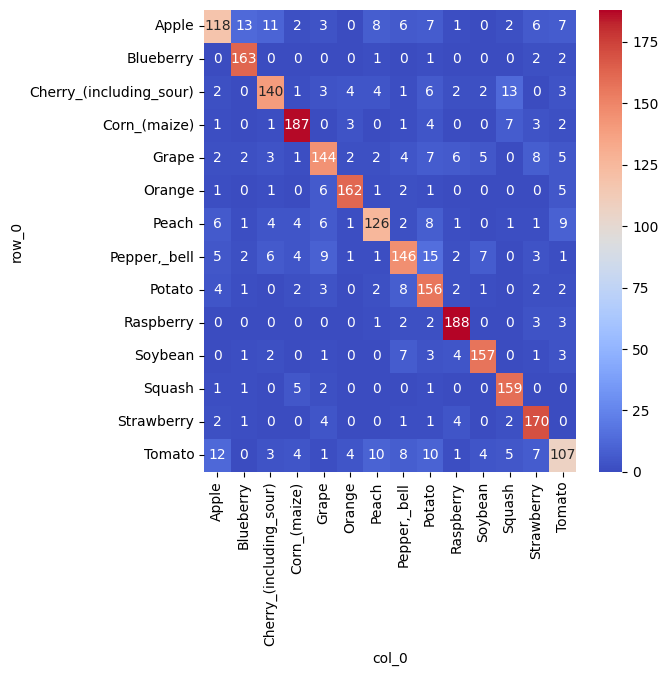

In [58]:
#Heatmap des corrélations
cor = pd.crosstab(y_valid_label, valid_pred_XGB_label)
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [ ]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelXGB_14.bin'
modelXGB.save_model(nomFicModele)